In [1]:
import requests
import importlib
import blizzard_api
import mysql
import mplusdb
import blizzard_credentials
import pandas as pd
import utils
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import sys

In [2]:
importlib.reload(mplusdb)
mdb = mplusdb.MplusDatabase('.db_config')
realms = mdb.get_utility_table('realm')
dungeons = mdb.get_utility_table('dungeon')
specs = mdb.get_utility_table('spec')

In [3]:
realm_clusters = realms[['cluster_id', 'region']].drop_duplicates()

In [4]:
auth = blizzard_credentials.Credentials('.api_tokens')
access_token = auth.access_token

In [5]:
# this is a bit anti-pattern, but the fastest way

# generate url calls for every valid combination of
# region/realm_cluster/dungeon/period

# S4 starts with period 734
region_encoder = {1:'us', 2:'kr', 3:'eu', 4:'tw'}

all_urls = []
urls_for_period_region_dungeon = {}
for _, row in dungeons.iterrows():
    dungeon_id = row[0]
    if dungeon_id < 244:
        continue;
    period_start = 764#734 #row[2]
    period_end = 769#763
    for _, realm in realm_clusters.iterrows():
        cluster_id = realm[0]
        region = region_encoder[realm[1]]
        url_factory = blizzard_api.UrlFactory(
            access_token = access_token, region=region)
        for period in range(period_start, period_end+1):
            url = url_factory.get_mythic_plus_leaderboard_url(
                dungeon_id = dungeon_id, realm_id = cluster_id,
                period = period)
            all_urls.append(url)
            #assign url to a sub-list by region-period
            key = (region, period, dungeon_id)
            if key in urls_for_period_region_dungeon:
                urls_for_period_region_dungeon[key].append(url)
            else:
                urls_for_period_region_dungeon[key] = []
                urls_for_period_region_dungeon[key].append(url)

In [6]:
len(urls_for_period_region_dungeon)

288

In [7]:
# check math by hand
calls_per_realm = (10 * (764-662)) + (33 * 2)
print('calls per realm', calls_per_realm)
print('total calls', calls_per_realm * len(realm_clusters))

calls per realm 1086
total calls 275844


In [8]:
print('total time (hrs):', len(all_urls) * 0.25 / 3600)
print('total space raw json (Gbs):', 1/1024 * 1.2 * len(all_urls))
print('total space python list (Gbs):', 1/1024 * 0.02 * len(all_urls))

total time (hrs): 1.27
total space raw json (Gbs): 21.43125
total space python list (Gbs): 0.3571875


#### How are we going to do this?

So we got 284,000 url calls we need to make. Each call takes on ~0.25 seconds on average (if we use 10 threads), and generates 1.2Mb of data.

```
Total data size = 273,304 * 1.2Mb = 320 Gb
```

The capacity of my DB is just 20Gb. Oh-oh. I don't even have the storage for this.

#### Is it really 1.2Mb per call? I don't think so:

The raw json is 1.2Mb. Once we extract the data, the list is only 20kb. So total is:

```
Total data size = 273,304 * 0.02Mb = 5 Gb
```

I have plenty of space for this. Yay. Let's proceed.

#### This is how we are going to proceed:
* Break up the API calls into segments based on region and time period. Each segment is a time period within a region, and there are 404 total segments.
* Query each segment, one at a time.
* Aggregate data for each segment, and push to DB
* Keep track of which segment is done using some form of logging

In [9]:
import datetime


class MyLogger():
    """wrapper for a simple logger"""
    __fp = 'logs/mdb_segments.log'
    def __init__(self):
        pass
    
    def log(self, segment_id):
        ts = time.time()
        ts = datetime.datetime.fromtimestamp(ts).strftime('%c')
        with open(self.__fp, 'a') as file:
            #file.write('%s\t%s\t%s\t%s\n' % (ts, segment_id))
            file.write('%s\t%s\n' % (ts, segment_id))
            
    def get_logged_keys(self):
        keys = []
        with open(self.__fp, 'r') as file:
            for line in file:
                key_token = line.split()[-1]
                key = key_token.split('_')
                keys.append((key[0], int(key[1]), int(key[2])))
        return keys

In [10]:
logger = MyLogger()
logged_keys = logger.get_logged_keys()
print(len(logged_keys))

1440


In [11]:
def divide_chunks(list_, n): 
    # looping till length l 
    for i in range(0, len(list_), n):  
        yield list_[i:i + n] 
        
list(divide_chunks(list(range(10)), 11))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [16]:
invalid_urls = []

In [17]:
importlib.reload(blizzard_api)
importlib.reload(mplusdb)

def divide_chunks(list_, n): 
    # looping till length l 
    for i in range(0, len(list_), n):  
        yield list_[i:i + n] 
        
        
def api_call(url):
    time.sleep(0.1)
    try:
        response = requests.get(url, timeout = 10)
    except:
        response = requests.get(url)
    #print(time.time())
    #response = 0
    return response

def api_call_session(urls):
    responses = []
    with requests.Session() as session:
        for url in urls:
            try:
                response = session.get(url, timeout = 10)
            except: 
                response = session.get(url, timeout = 10)
            responses.append(response)
    return responses

def multi_threaded_call_chunked(urls):
    """Sends multiple calls to the API at once."""
    
    #chunk the urls into pieces with 10 urls each
    url_chunks = divide_chunks(urls, 10)
        
    threads = []
    with ThreadPoolExecutor(max_workers = 10) as executor:
        for chunk in url_chunks:
            threads.append(executor.submit(api_call_session, chunk))
    agg_result = []
    for task in as_completed(threads):
        agg_result.extend(task.result())
    return agg_result
    

def multi_threaded_call(urls):
    """Sends multiple calls to the API at once."""
    threads = []
    with ThreadPoolExecutor(max_workers = 10) as executor:
        for url in urls:
            threads.append(executor.submit(api_call, url))
    agg_result = []
    for task in as_completed(threads):
        agg_result.append(task.result())
    return agg_result



def agg_leaderboards(responses):
    """Joins output of several leaderboards into single list."""
    parser = blizzard_api.ResponseParser()
    
    runs = []
    comps = []
    rosters = []
            
    for resp in responses:
        try:
            leaderboard = parser.parse_keyrun_leaderboard_json(resp.json())
            runs.extend(leaderboard.get_runs_as_tuple_list())
            rosters.extend(leaderboard.get_rosters_as_tuple_list())
            comps.extend(leaderboard.get_run_comps_as_vector_list())
        except:
            invalid_urls.append(resp.url)
            
    return runs, comps, rosters

mdb = mplusdb.MplusDatabase('.db_config')

segment = []
t0 = time.time()
i = 0

logger = MyLogger()
logged_keys = logger.get_logged_keys() # segments already done

for key, urls in urls_for_period_region_dungeon.items():
    if key in logged_keys:
        i += 1
        print(key, i)
        continue
    print(key)
    print(len(urls))
    print(datetime.datetime.now())
    t00 = time.time()
    responses = None
    #responses = multi_threaded_call(urls)
    responses = multi_threaded_call_chunked(urls)
    t1 = time.time()
    print('api calls', t1 - t00)
    runs, comps, rosters = agg_leaderboards(responses)
    t2 = time.time()
    print('parsing jsons', t2 - t1)
    runs = list(set(runs))
    rosters = list(set(rosters))
    comps = list(set(comps))
    t3 = time.time()
    print('set(data)', t3 - t2)
    
    
    
    comps = sorted(comps, key = lambda x: x[0])
    rosters = sorted(rosters, key = lambda x: x[0])
    
    mdb.insert(table = 'run', data = runs)
    t4 = time.time()
    print('inserting runs', t4 - t3)
    
    mdb.insert(table = 'roster', data = rosters)
    t5 = time.time()
    print('inserting rosters', t5 - t4)
    
    mdb.insert(table = 'run_composition', data = comps)
    t5 = time.time()
    print('inserting comps', t5 - t4)
    
    print(len(runs))
    print(len(comps))
    print(len(rosters))
    i += 1
    logger.log('%s_%s_%s' % key)
    print('-------------------')
    if i % 10 == 0:
        time.sleep(2)
    if i == 1500:
        break
print('total', time.time() - t0)

('us', 764, 244)
115
2020-09-26 02:33:16.191813
api calls 19.92448401451111
parsing jsons 2.7440197467803955
set(data) 0.08611392974853516
inserting runs 4.72520112991333
inserting rosters 37.098753690719604
inserting comps 54.90303421020508
21387
21111
108952
-------------------
('us', 765, 244)
115
2020-09-26 02:34:38.576299
api calls 18.0990309715271
parsing jsons 2.757021427154541
set(data) 0.09034204483032227
inserting runs 3.6945674419403076
inserting rosters 25.497936248779297
inserting comps 32.00813579559326
18283
17966
94464
-------------------
('us', 766, 244)
115
2020-09-26 02:35:35.226439
api calls 12.383561849594116
parsing jsons 2.455627202987671
set(data) 0.08988380432128906
inserting runs 3.2670154571533203
inserting rosters 21.924866914749146
inserting comps 28.122902154922485
15860
15650
81240
-------------------
('us', 767, 244)
115
2020-09-26 02:36:21.547061
api calls 13.601240158081055
parsing jsons 2.260202646255493
set(data) 0.08082127571105957
inserting runs 2.

parsing jsons 1.705984115600586
set(data) 0.06611776351928711
inserting runs 1.439992904663086
inserting rosters 11.60964846611023
inserting comps 25.002187490463257
8888
8895
44549
-------------------
('kr', 764, 245)
9
2020-09-26 03:06:57.867013
api calls 42.99002146720886
parsing jsons 0.3827664852142334
set(data) 0.010223388671875
inserting runs 0.6260049343109131
inserting rosters 6.449359178543091
inserting comps 18.11314630508423
3078
3010
16003
-------------------
('kr', 765, 245)
9
2020-09-26 03:07:59.990104
api calls 50.490052700042725
parsing jsons 0.30828309059143066
set(data) 0.009294748306274414
inserting runs 0.9831843376159668
inserting rosters 6.223571062088013
inserting comps 17.33274006843567
3070
2917
16304
-------------------
('kr', 766, 245)
9
2020-09-26 03:09:09.114862
api calls 40.456969261169434
parsing jsons 0.25719571113586426
set(data) 0.0068819522857666016
inserting runs 0.7390985488891602
inserting rosters 5.444361209869385
inserting comps 12.4771695137023

inserting rosters 2.2539162635803223
inserting comps 4.935782194137573
1129
1124
5670
-------------------
('kr', 769, 246)
9
2020-09-26 03:47:50.284112
api calls 11.78492546081543
parsing jsons 0.038074493408203125
set(data) 0.001436471939086914
inserting runs 6.2895355224609375
inserting rosters 2.407419443130493
inserting comps 3.667860507965088
491
491
2449
-------------------
('eu', 764, 246)
121
2020-09-26 03:48:14.069115
api calls 64.87178087234497
parsing jsons 3.07804012298584
set(data) 0.10171127319335938
inserting runs 4.474196672439575
inserting rosters 41.34732747077942
inserting comps 113.33797836303711
20733
20124
105345
-------------------
('eu', 765, 246)
121
2020-09-26 03:51:19.934018
api calls 64.32618165016174
parsing jsons 2.9008936882019043
set(data) 0.09942507743835449
inserting runs 3.907330274581909
inserting rosters 43.37118649482727
inserting comps 117.7263388633728
17393
16862
88660
-------------------
('eu', 766, 246)
121
2020-09-26 03:54:28.895393
api calls

api calls 64.54009675979614
parsing jsons 2.844454288482666
set(data) 0.1095588207244873
inserting runs 5.493290424346924
inserting rosters 44.16428303718567
inserting comps 133.64052295684814
17123
17093
85711
-------------------
('eu', 769, 247)
121
2020-09-26 04:46:32.519933
api calls 34.45940446853638
parsing jsons 1.702388048171997
set(data) 0.07002449035644531
inserting runs 2.3525514602661133
inserting rosters 17.98040199279785
inserting comps 58.04963946342468
7918
7918
39601
-------------------
('tw', 764, 247)
9
2020-09-26 04:48:11.157489
api calls 44.84754705429077
parsing jsons 0.25651979446411133
set(data) 0.009126901626586914
inserting runs 1.2126586437225342
inserting rosters 5.604745388031006
inserting comps 8.620529413223267
1529
1632
9243
-------------------
('tw', 765, 247)
9
2020-09-26 04:49:06.105137
api calls 34.242764949798584
parsing jsons 0.21406078338623047
set(data) 0.007207393646240234
inserting runs 17.388620853424072
inserting rosters 5.180773019790649
ins

inserting rosters 4.551535129547119
inserting comps 6.959261655807495
931
1047
5270
-------------------
('tw', 768, 248)
9
2020-09-26 05:35:32.647416
api calls 21.38067054748535
parsing jsons 0.12491869926452637
set(data) 0.0028684139251708984
inserting runs 21.60986590385437
inserting rosters 4.131085634231567
inserting comps 6.9754393100738525
787
885
4320
-------------------
('tw', 769, 248)
9
2020-09-26 05:36:22.742375
api calls 7.898395538330078
parsing jsons 0.03030085563659668
set(data) 0.001535654067993164
inserting runs 4.873799800872803
inserting rosters 2.1926400661468506
inserting comps 3.1054270267486572
215
236
1151
-------------------
('us', 764, 249)
115
2020-09-26 05:36:40.655010
api calls 17.036038875579834
parsing jsons 2.435878038406372
set(data) 0.07651877403259277
inserting runs 5.908447742462158
inserting rosters 61.142088890075684
inserting comps 202.87869453430176
18692
18436
95324
-------------------
('us', 765, 249)
115
2020-09-26 05:40:28.991821
api calls 21

api calls 14.16445255279541
parsing jsons 2.0208206176757812
set(data) 0.0776059627532959
inserting runs 7.108797550201416
inserting rosters 52.15380239486694
inserting comps 134.29164505004883
12829
12751
65116
-------------------
('us', 768, 250)
115
2020-09-26 06:35:32.205406
api calls 18.894871711730957
parsing jsons 2.101188898086548
set(data) 0.07714128494262695
inserting runs 5.76031231880188
inserting rosters 32.516594886779785
inserting comps 145.10352182388306
12883
12860
64691
-------------------
('us', 769, 250)
115
2020-09-26 06:38:24.143779
api calls 13.41899299621582
parsing jsons 1.2575392723083496
set(data) 0.05057549476623535
inserting runs 2.688685894012451
inserting rosters 35.22077536582947
inserting comps 70.24708962440491
6446
6456
32314
-------------------
('kr', 764, 250)
9
2020-09-26 06:39:53.811685
api calls 56.50786566734314
parsing jsons 0.2651951313018799
set(data) 0.0070040225982666016
inserting runs 1.6874020099639893
inserting rosters 6.7069714069366455

inserting runs 1.440901279449463
inserting rosters 6.124420404434204
inserting comps 12.645407915115356
2148
1993
11188
-------------------
('kr', 767, 251)
9
2020-09-26 07:32:58.483447
api calls 29.12561345100403
parsing jsons 0.1563889980316162
set(data) 0.004228830337524414
inserting runs 1.478011131286621
inserting rosters 6.105364799499512
inserting comps 12.81803297996521
1720
1634
8822
-------------------
('kr', 768, 251)
9
2020-09-26 07:33:42.066938
api calls 23.52448558807373
parsing jsons 0.1320507526397705
set(data) 0.003099679946899414
inserting runs 1.433708906173706
inserting rosters 5.65715217590332
inserting comps 16.56171488761902
1448
1428
7293
-------------------
('kr', 769, 251)
9
2020-09-26 07:34:23.723825
api calls 13.154062032699585
parsing jsons 0.09644603729248047
set(data) 0.0019161701202392578
inserting runs 7.384164571762085
inserting rosters 2.929962635040283
inserting comps 7.685001850128174
740
740
3699
-------------------
('eu', 764, 251)
121
2020-09-26 

api calls 45.52910804748535
parsing jsons 2.373521327972412
set(data) 0.09060263633728027
inserting runs 6.082105398178101
inserting rosters 57.59737849235535
inserting comps 154.53574967384338
13369
13117
67915
-------------------
('eu', 767, 252)
121
2020-09-26 08:35:22.797971
api calls 37.45552062988281
parsing jsons 2.2114126682281494
set(data) 0.08800411224365234
inserting runs 6.127929925918579
inserting rosters 50.40406131744385
inserting comps 148.881897687912
12185
12083
61280
-------------------
('eu', 768, 252)
121
2020-09-26 08:38:37.563881
api calls 46.762166261672974
parsing jsons 2.3578813076019287
set(data) 0.09577345848083496
inserting runs 6.218153953552246
inserting rosters 39.49274802207947
inserting comps 146.05940699577332
13137
13117
65735
-------------------
('eu', 769, 252)
121
2020-09-26 08:41:59.058519
api calls 28.702236890792847
parsing jsons 1.1597247123718262
set(data) 0.047949790954589844
inserting runs 2.3315536975860596
inserting rosters 13.40479302406

inserting rosters 4.447657346725464
inserting comps 7.774527549743652
1124
1189
6630
-------------------
('tw', 766, 353)
9
2020-09-26 09:31:22.013576
api calls 29.46372389793396
parsing jsons 0.13939881324768066
set(data) 0.003597259521484375
inserting runs 0.7619383335113525
inserting rosters 2.4026131629943848
inserting comps 5.932760715484619
833
1016
5078
-------------------
('tw', 767, 353)
9
2020-09-26 09:31:58.317280
api calls 23.923418760299683
parsing jsons 0.1672220230102539
set(data) 0.003617525100708008
inserting runs 0.2778918743133545
inserting rosters 2.647205114364624
inserting comps 5.66549277305603
801
912
4578
-------------------
('tw', 768, 353)
9
2020-09-26 09:32:28.356098
api calls 22.86412787437439
parsing jsons 0.12344193458557129
set(data) 0.003099203109741211
inserting runs 1.79194974899292
inserting rosters 3.4935646057128906
inserting comps 7.064190626144409
740
837
4133
-------------------
('tw', 769, 353)
9
2020-09-26 09:33:00.204666
api calls 7.769699335

api calls 13.81303596496582
parsing jsons 2.4573493003845215
set(data) 0.08600187301635742
inserting runs 16.05431365966797
inserting rosters 85.66030526161194
inserting comps 253.78248238563538
18216
17918
93946
-------------------
('us', 766, 370)
115
2020-09-26 10:41:55.664268
api calls 18.320887088775635
parsing jsons 2.363832950592041
set(data) 0.07775616645812988
inserting runs 10.274620056152344
inserting rosters 81.56243562698364
inserting comps 216.12677836418152
16152
15969
82799
-------------------
('us', 767, 370)
115
2020-09-26 10:46:02.829606
api calls 16.931336641311646
parsing jsons 2.181226968765259
set(data) 0.08058691024780273
inserting runs 9.181408405303955
inserting rosters 60.58128619194031
inserting comps 174.6803526878357
14276
14171
72283
-------------------
('us', 768, 370)
115
2020-09-26 10:49:25.886142
api calls 16.48863959312439
parsing jsons 2.129962205886841
set(data) 0.08417773246765137
inserting runs 7.232176065444946
inserting rosters 68.3298602104187

In [14]:
resp

NameError: name 'resp' is not defined

In [17]:
#JSONDecodeError: Expecting value: line 1 column 1 (char 0)
# 105 - 116 || 20k
# 142 - 157 || 25k
# 46  - 56  || 24k
# 82  - 93  || 27k

In [ ]:
test_rq.json()

In [ ]:
1.5*1440/60

In [ ]:
importlib.reload(utils)
importlib.reload(blizzard_api)
all_urls[0]

t0 = time.time()
test_rq = requests.get(all_urls[0])
print(time.time() - t0)
test_klb = blizzard_api.KeyRunLeaderboard(test_rq.json())

In [ ]:
test_klb.keyruns[0].get_composition_vector()
t0 = time.time()
comps = test_klb.get_run_comps_as_vector_list()
print(time.time()-t0)
print(comps)

In [ ]:
tuple([1,2])

In [ ]:
print(len(set(comps)))

In [ ]:
#import pickle
#pickle.dump(leaderboard.get_runs_as_tuple_list(), open('test_objs.pkl', 'wb'))
#print(leaderboard.keyruns)

In [15]:
period = [734, 552152,
735, 573429,
736, 600545,
737, 533797,
738, 600092,
739, 574013,
740, 632797,
741, 566984,
742, 530253,
743, 602726,
744, 619092,
745, 675847,
746, 664888,
747, 687195,
748, 715860,
749, 621633,
750, 734762,
751, 750325,
752, 718098,
753, 695534,
754, 693893,
755, 629968,
756, 607517,
757, 627584,
758, 601825,
759, 551282,
760, 606719,
761, 565799,
762, 604201,
763, 496264]


In [18]:
per = [i for i in period if i < 800]
pop = [i for i in period if i > 100000]

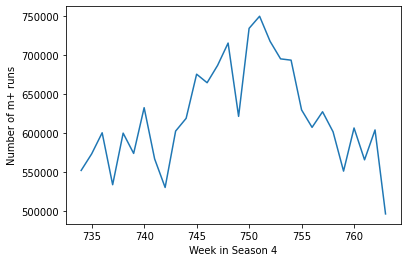

In [22]:
fig = plt.figure()
plt.plot(per, pop)
plt.xlabel('Week in Season 4')
plt.ylabel('Number of m+ runs')
plt.show()